In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

#### when looking to make a neural network we need to decide upon the activation function first.
#### we have many options available to us

In [4]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # this unsqueeze is being done to parallelize the input
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

t_u.shape

torch.Size([11, 1])

In [5]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 3, 10,  5,  2,  7,  4,  0,  8,  1]), tensor([9, 6]))

In [6]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [7]:
#our basic neuron is built from the torch.nn submodule
#we solve our temperature conversion using a linear neuron unit
import torch.nn as nn

linear_model = nn.Linear(1, 1) # <1>
linear_model(t_un_val)


tensor([[-1.8575],
        [-0.8784]], grad_fn=<AddmmBackward>)

Every submodule of the nn.Module has a function \__call__ which allows us to use it as if it were a regular function. 
The diff between \__call__ and forward is that the latter just does a simple forward pass, but \__call__ does other relavant stuff before and after calling forward itself

In [8]:
#__call__ is simply done as below
# y = model(x)
# using forward directly as shown below is not the correct way of computing
# y = model.forward(x)

In [9]:
#Returning to the linear model
import torch.nn as nn
linear_model = nn.Linear(1, 1) #1 and 1 are the sizes of input and output tensors
linear_model(t_un_val)

tensor([[-5.7330],
        [-3.4839]], grad_fn=<AddmmBackward>)

In [10]:
#we can check weights and biases as follows
linear_model.weight, linear_model.bias

(Parameter containing:
 tensor([[-0.8487]], requires_grad=True),
 Parameter containing:
 tensor([-0.6067], requires_grad=True))

In [11]:
#calling model with sample input
x = torch.ones(1)
linear_model(x)

tensor([-1.4555], grad_fn=<AddBackward0>)

Usually pytorch expects inputs to be in batches, with the zeroth input being the number of batches. 

We can batch our inputs as follows

In [12]:
x = torch.ones(10, 1)
linear_model(x)


tensor([[-1.4555],
        [-1.4555],
        [-1.4555],
        [-1.4555],
        [-1.4555],
        [-1.4555],
        [-1.4555],
        [-1.4555],
        [-1.4555],
        [-1.4555]], grad_fn=<AddmmBackward>)

In [13]:
# changing our model to use an optimizer
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

In [14]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)
        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f}," f" Validation loss {loss_val.item():.4f}")

In [15]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)
training_loop(
n_epochs = 3000,
optimizer = optimizer,
model = linear_model,
loss_fn = nn.MSELoss(),
t_u_train = t_un_train,
t_u_val = t_un_val,
t_c_train = t_c_train,
t_c_val = t_c_val)
print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 319.9083, Validation loss 155.8594
Epoch 1000, Training loss 3.5572, Validation loss 2.8463
Epoch 2000, Training loss 2.4799, Validation loss 5.1550
Epoch 3000, Training loss 2.4449, Validation loss 5.7270

Parameter containing:
tensor([[5.5780]], requires_grad=True)
Parameter containing:
tensor([-18.4051], requires_grad=True)


In [16]:
#creating our own neural network model from the sequential submodule
seq_model = nn.Sequential(
                nn.Linear(1, 13),
                nn.Tanh(),
                nn.Linear(13, 1)) #13 is an arbitrarily chosen number

seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [19]:
#running the training llop for the new model defined above
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)
training_loop(
n_epochs = 5000,
optimizer = optimizer,
model = seq_model,
loss_fn = nn.MSELoss(),
t_u_train = t_un_train,
t_u_val = t_un_val,
t_c_train = t_c_train,
t_c_val = t_c_val)
print('output', seq_model(t_un_val))
print('answer', t_c_val)


Epoch 1, Training loss 0.9999, Validation loss 8.7184
Epoch 1000, Training loss 0.9507, Validation loss 10.4123
Epoch 2000, Training loss 0.9267, Validation loss 10.3473
Epoch 3000, Training loss 0.9108, Validation loss 10.2948
Epoch 4000, Training loss 0.8993, Validation loss 10.2496
Epoch 5000, Training loss 0.8906, Validation loss 10.2096
output tensor([[15.6557],
        [-0.4335]], grad_fn=<AddmmBackward>)
answer tensor([[13.],
        [ 3.]])


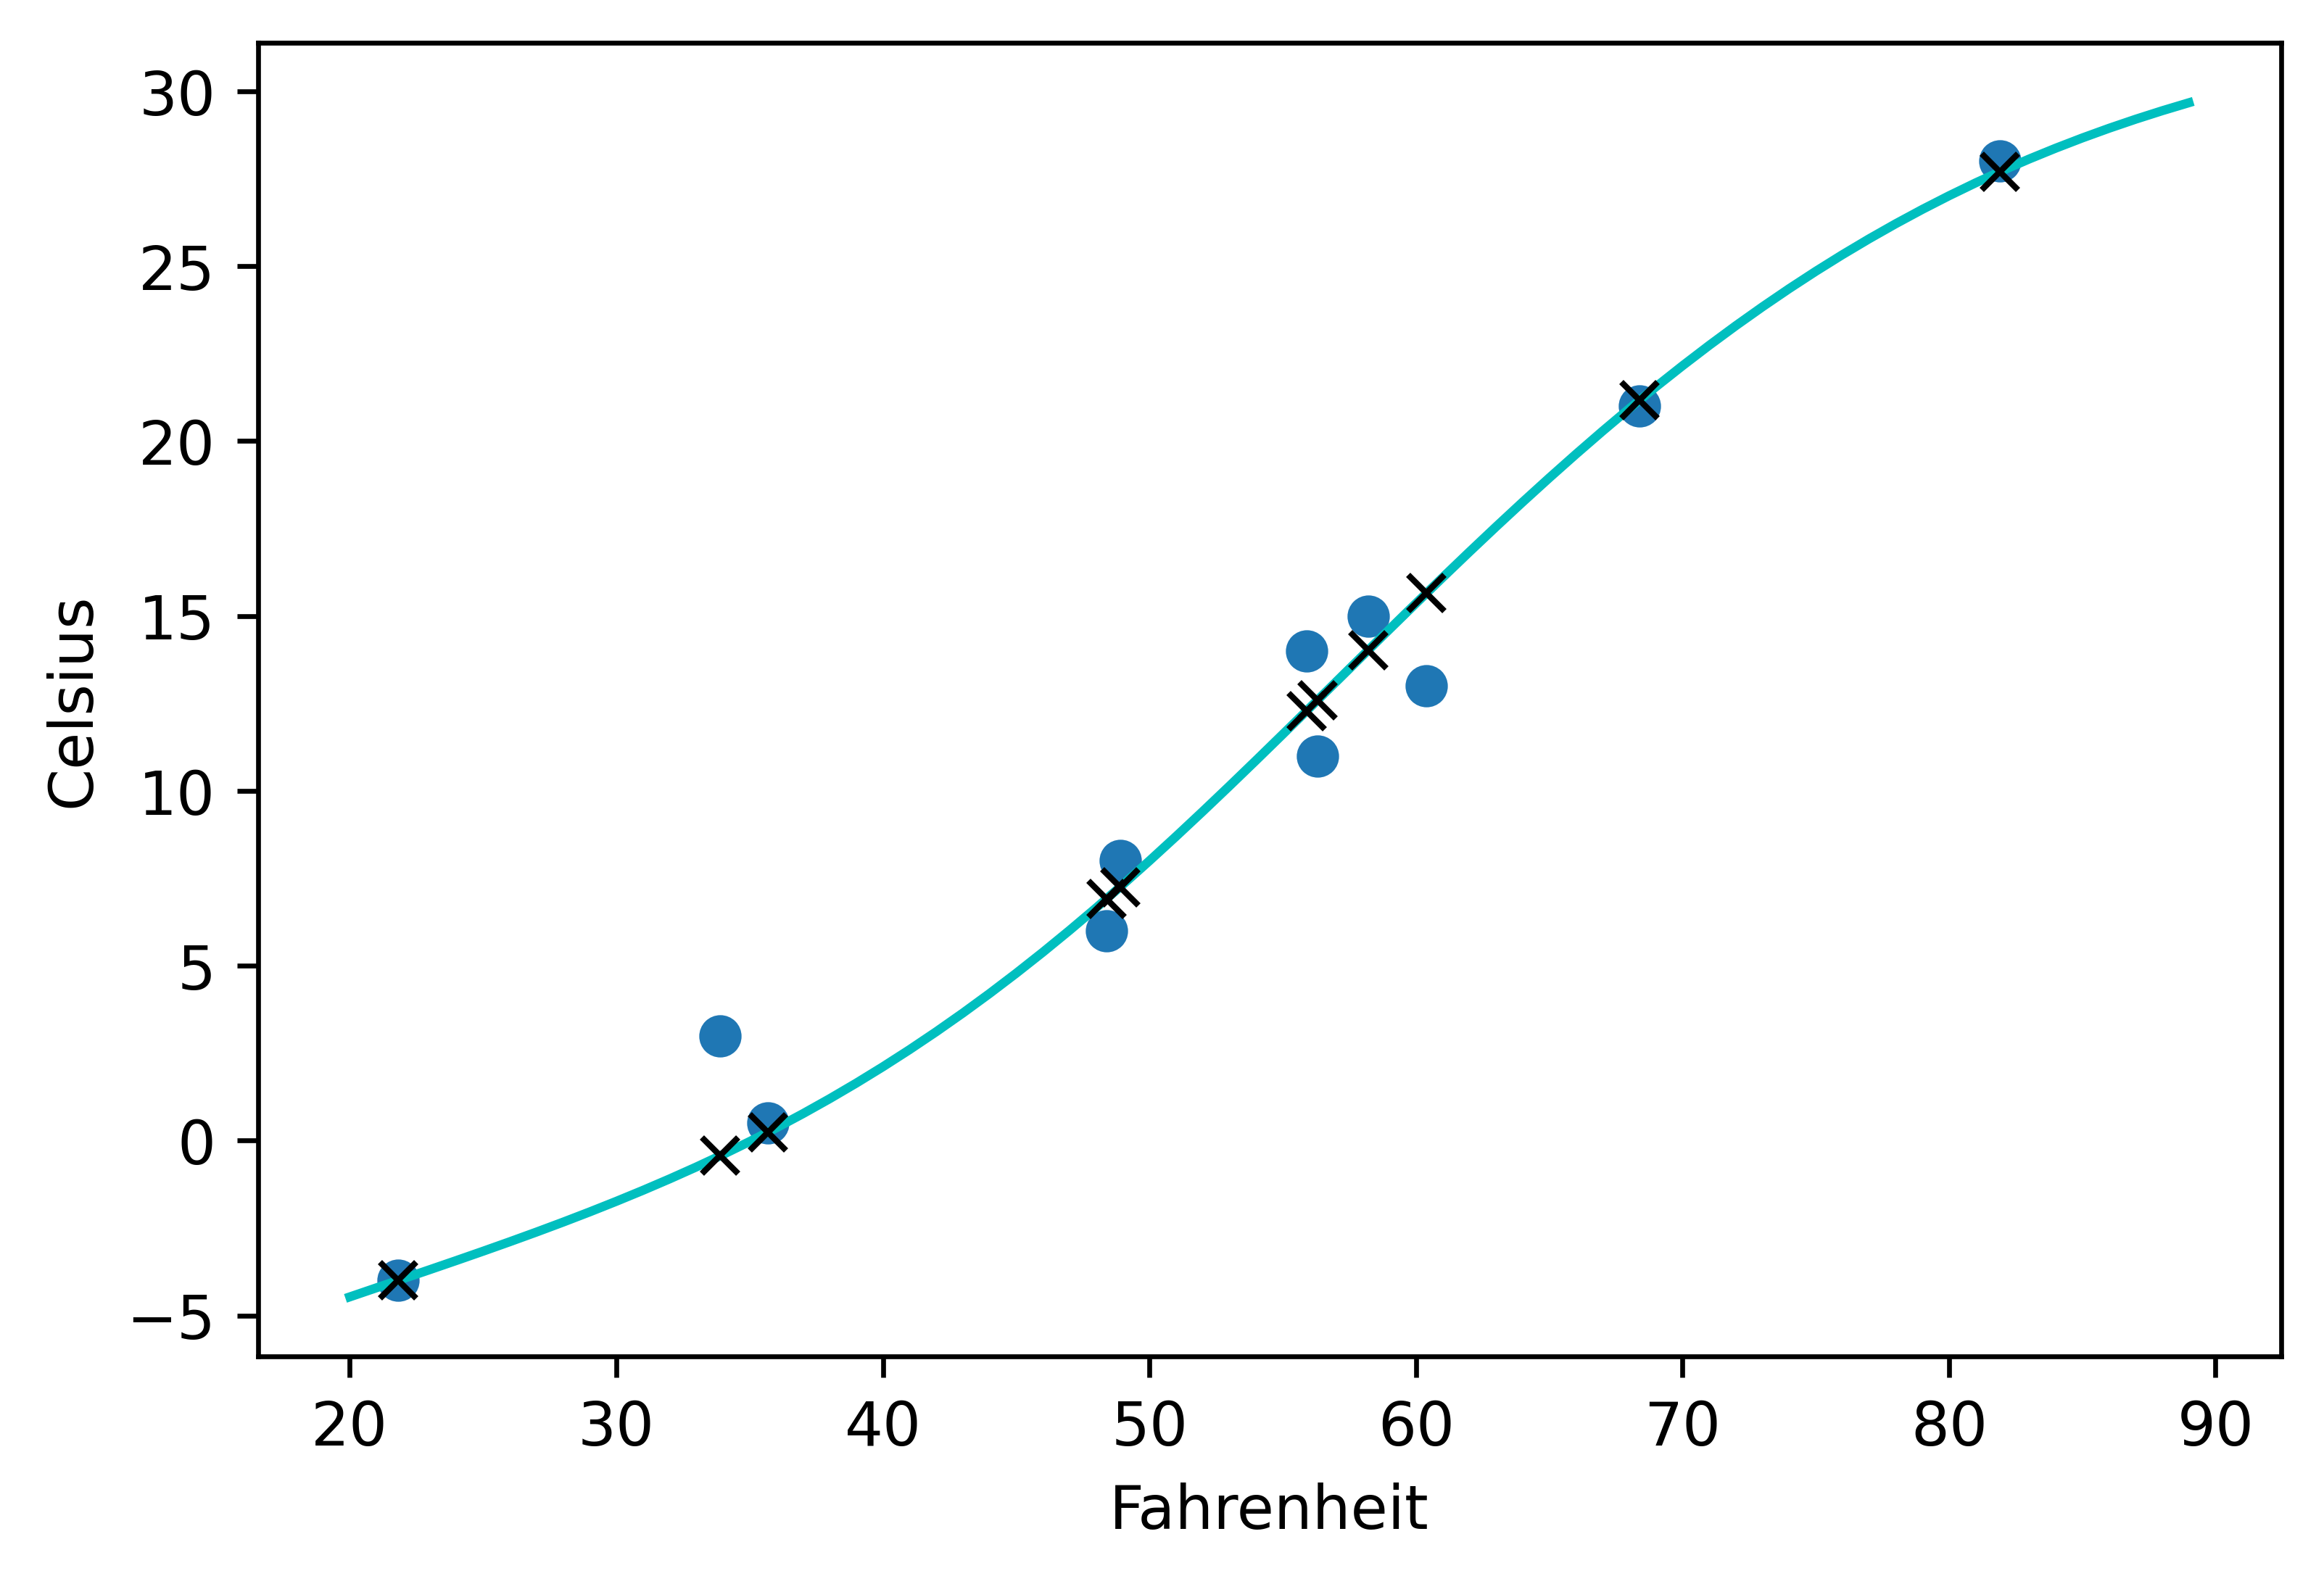

In [20]:
#plotting to compare
from matplotlib import pyplot as plt
t_range = torch.arange(20., 90.).unsqueeze(1)
fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')